In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
from IPython.display import clear_output
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display
from thermo_models.VLEEmpiricalModel import *
from scipy.misc import derivative as der
import math
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from scipy.optimize import fsolve
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
from utils.AntoineEquation import * 
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationTernary import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.WilsonModel import *

In [2]:
P_sys = 101325 #1 atm in pascals
num_comp = 3
Lambdas = {
    (1,1) : 1,
    (1,2) : 0.1782,
    (1,3) : 0.692,
    (2,1) : 0.8966,
    (2,2) : 1,
    (2,3) : 0.492,
    (3,1) : 0.726,
    (3,2) : 0.066,
    (3,3) : 1
    }

#Antoine parameters for Ethanol
EtOH_A = 23.5807
EtOH_B = 3673.81
EtOH_C = -46.681

#Antoine parameters for Water
H2O_A = 23.2256
H2O_B = 3835.18
H2O_C = -45.343

#Antoine parameters for Methanol
Me_A = 23.4832
Me_B = 3634.01
Me_C = -33.768

xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.990, 0.009, 1e-3])
xB = np.array([1e-10, 0.01,0.9897])
r = 0 # starting value

#Antoine Equations 
EtOH_antoine = AntoineEquationBaseE(EtOH_A, EtOH_B, EtOH_C)
H2O_antoine = AntoineEquationBaseE(H2O_A, H2O_B, H2O_C)
Methanol_antoine = AntoineEquationBaseE(Me_A, Me_B, Me_C)

vle_model = WilsonModel(num_comp,P_sys,Lambdas,[EtOH_antoine, Methanol_antoine, H2O_antoine])
distillation_model = DistillationModelTernary(vle_model, xF = xF, xD = xD, xB = xB, reflux = r)

# u1 = x1, u2 = x2
def eqns(uvec, l):
    u1 = uvec[0]; u2 = uvec[1]
    res = np.zeros(2)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(np.array([u1, u2, 1-u1-u2]))[0]
    rectifying_sol = distillation_model.change_r(l).rectifying_step_xtoy(np.array([u1, u2, 1-u1-u2]))

    res[0] = thermo_sol[0] - rectifying_sol[0]
    res[1] = thermo_sol[1] - rectifying_sol[1]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = ((uvec[0] - u0[0])*tau[0]) + ((uvec[1] - u0[1])*tau[1]) + ((uvec[2] - u0[2])*tau[2]) - ds

    return res

ds = 0.0001
num_steps = 50000
lam_m1 = 0.001
old_sol_m1 = fsolve(eqns, x0=np.array([0.001, 0.001]), args=(lam_m1,))
lam_0 = lam_m1 + ds
old_sol = fsolve(eqns, x0=old_sol_m1, args=(lam_0,))

u1_sol = np.zeros((num_steps))
u2_sol = np.zeros((num_steps))
l_sol  = np.zeros((num_steps))

for i in range(num_steps):
    if i % 1000 == 0:
        print(i)
    # Solve for tangent vector
    del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], lam_0])
    new_sol     = fsolve(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol))
    
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    if abs(lam_m1 - lam_0) > 1:
        break
    
    u1_sol[i] = old_sol[0]
    u2_sol[i] = old_sol[1]
    l_sol[i] = lam_0

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


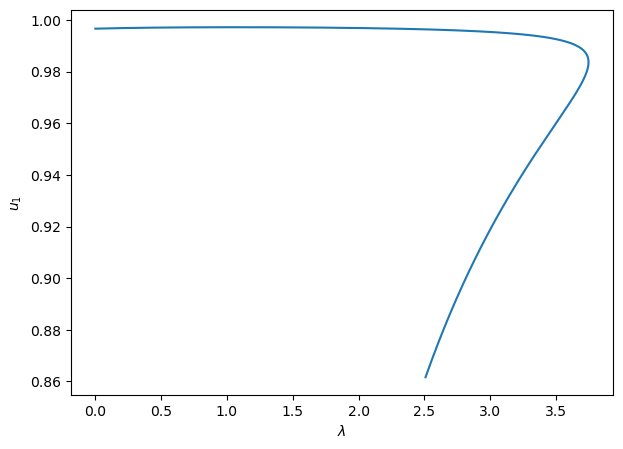

In [3]:
fig, ax = plt.subplots(figsize = (7,5))

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()